In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.cluster import KMeans

names_bw=['time', 'bw', 'op1', 'size', 'op2' ]
names_latency=['time', 'latency', 'op2', 'write_size', 'op3']

/tmp/ipykernel_205196/1663137476.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[submission_time:completion_time] += write_rate_per_ms


Average1: 2
Average2: 145


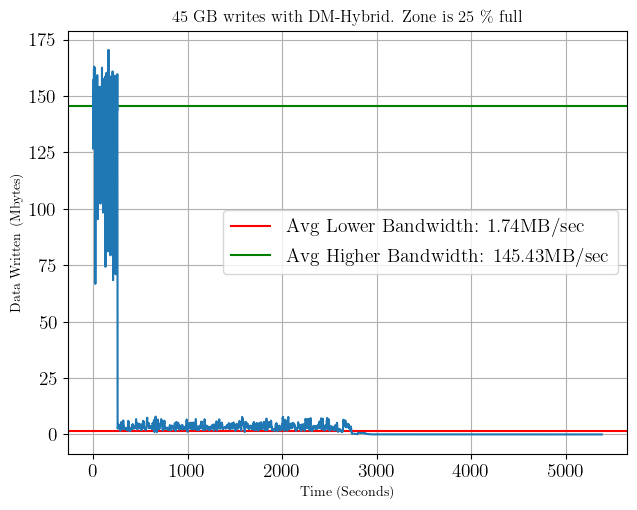

/tmp/ipykernel_205196/1663137476.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797
 20301.48216797 20301.48216797 20301.48216797 20301.48216797]' has dtype incompatible with int64, please expli

Average1: 1
Average2: 144


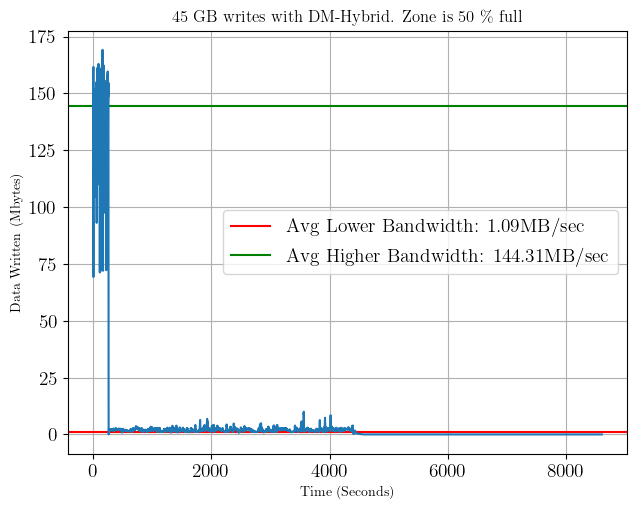

/tmp/ipykernel_205196/1663137476.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439

In [43]:
# Define a custom grouping function
def custom_grouping(index):
    return index // 1000
    
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']
dirs = ["25Util", "50Util", "90Util"]
#runs = ["run2", "run1"]

for dir in dirs:
    # Step 1: Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/{dir}/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
    df['submission_time'] = df['submission_time'] - df.iloc[0].submission_time
    df['duration'] = df['duration']/1e6 #convert ns to ms
    df['completion_time'] = df['submission_time'] + df['duration']
    # Step 2: Convert submission time and completion time columns to datetime objects with unit as milliseconds
    df['submission_time'] = pd.to_datetime(df['submission_time'], unit='ms')
    df['completion_time'] = pd.to_datetime(df['completion_time'], unit='ms')
    #print(df)

    # Step 3: Determine the start and end time of the entire test
    start_time = df['submission_time'].min()
    end_time = df['completion_time'].max()

    # Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
    time_index_ms = pd.date_range(start=start_time, end=end_time, freq='ms')
    data_written_ms = pd.DataFrame(index=time_index_ms, columns=['data_written_bytes'])
    data_written_ms['data_written_bytes'] = 0

    # Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
    for index, row in df.iterrows():
        submission_time = row['submission_time']
        completion_time = row['completion_time']
        write_size_bytes = 1048576  # 1 MB in bytes
        duration_ms = row['duration']
        write_rate_per_ms = write_size_bytes / duration_ms
        data_written_ms.loc[submission_time:completion_time] += write_rate_per_ms

    # Reset the index to convert the time index to a regular integer index
    data_written_ms.reset_index(drop=True, inplace=True)
    df_grouped = data_written_ms.groupby(custom_grouping).sum()
    # Reset the index to make it a regular column
    df_grouped.reset_index(inplace=True)
    df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
    df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2)

    data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data_array)
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_.flatten()
    # Sort cluster centers to get the lowest and highest modes
    cluster_centers.sort()
    # Calculate the average of each mode
    average_mode1 = cluster_centers[0]
    average_mode2 = cluster_centers[1]
    print("Average1: " + str(round(average_mode1, )))
    print("Average2: " + str(round(average_mode2, )))
    avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
    avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
    fig, ax = plt.subplots()
    plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
    plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)
    plt.legend(loc='center right', fontsize=14)
    # Plot the data size over time for each resolution
    #plt.figure(figsize=(8, 6), dpi=80)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    ax.plot(df_grouped.index, df_grouped['data_written_bytes'])
    #plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Data Written (Mbytes)')
    plt.grid(True)  # Optionally, add grid lines
    name=dir.split("Util")
    plt.title(f"45 GB writes with DM-Hybrid. Zone is {name[0]} \% full")
       
    plt.savefig(f'/home/surbhi/github/surbhi-plots/new/STL/{dir}_run1.png', bbox_inches='tight')
    plt.show()
    


/tmp/ipykernel_205196/208357431.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[56504.25103722 56504.25103722 56504.25103722 56504.25103722
 56504.25103722 56504.25103722 56504.25103722 56504.25103722
 56504.25103722 56504.25103722 56504.25103722 56504.25103722
 56504.25103722 56504.25103722 56504.25103722 56504.25103722
 56504.25103722 56504.25103722 56504.25103722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[submission_time:completion_time] += write_rate_per_ms


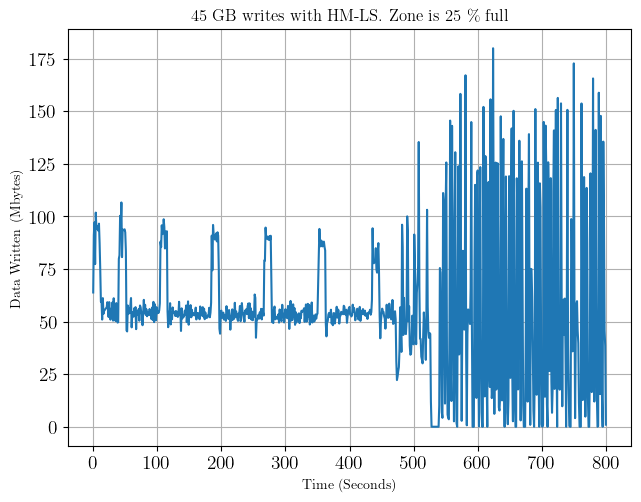

/tmp/ipykernel_205196/208357431.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[54590.01032007 54590.01032007 54590.01032007 54590.01032007
 54590.01032007 54590.01032007 54590.01032007 54590.01032007
 54590.01032007 54590.01032007 54590.01032007 54590.01032007
 54590.01032007 54590.01032007 54590.01032007 54590.01032007
 54590.01032007 54590.01032007 54590.01032007 54590.01032007]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[submission_time:completion_time] += write_rate_per_ms


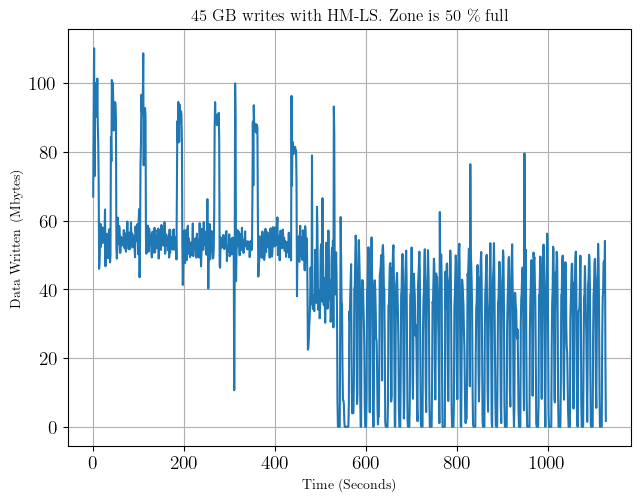

/tmp/ipykernel_205196/208357431.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[submission_time:completion_time] += write_rate_per_ms


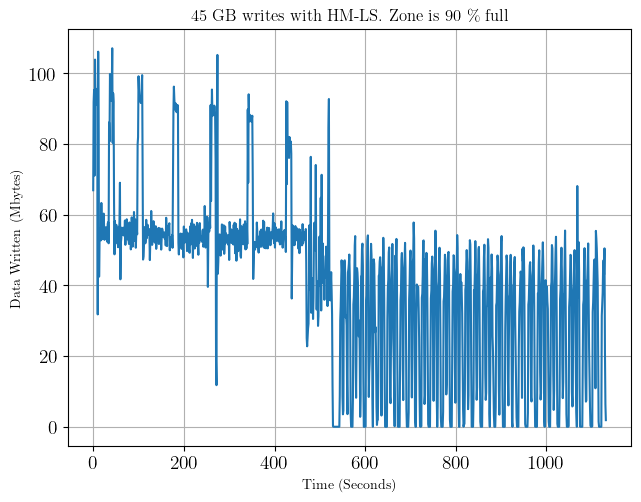

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
names_latency=['generation_time_sec', 'completion_time_ns', 'op2', 'write_size', 'op3']
dirs = ["25Util", "50Util", "90Util"]
# Define a custom grouping function
def custom_grouping(index):
    return index // 1000
    
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']
dirs = ["25Util", "50Util", "90Util"]
#runs = ["run2", "run1"]

for dir in dirs:
    # Step 1: Read the CSV file into a Pandas DataFrame
    #/home/surbhi/measurements/worst_case/lsdm/lsdm-util/25Util/1MB/8TB/90-10-LBA/45GB
    df = pd.read_csv(f'/home/surbhi/measurements/worst_case/lsdm/lsdm-util/{dir}/1MB/8TB/90-10-LBA/45GB/lat_log_avg_lat.1.log', names=names_latency)
    df['submission_time'] = df['submission_time'] - df.iloc[0].submission_time
    df['duration'] = df['duration']/1e6 #convert ns to ms
    df['completion_time'] = df['submission_time'] + df['duration']
    # Step 2: Convert submission time and completion time columns to datetime objects with unit as milliseconds
    df['submission_time'] = pd.to_datetime(df['submission_time'], unit='ms')
    df['completion_time'] = pd.to_datetime(df['completion_time'], unit='ms')
    #print(df)

    # Step 3: Determine the start and end time of the entire test
    start_time = df['submission_time'].min()
    end_time = df['completion_time'].max()

    # Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
    time_index_ms = pd.date_range(start=start_time, end=end_time, freq='ms')
    data_written_ms = pd.DataFrame(index=time_index_ms, columns=['data_written_bytes'])
    data_written_ms['data_written_bytes'] = 0

    # Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
    for index, row in df.iterrows():
        submission_time = row['submission_time']
        completion_time = row['completion_time']
        write_size_bytes = 1048576  # 1 MB in bytes
        duration_ms = row['duration']
        write_rate_per_ms = write_size_bytes / duration_ms
        data_written_ms.loc[submission_time:completion_time] += write_rate_per_ms

    # Reset the index to convert the time index to a regular integer index
    data_written_ms.reset_index(drop=True, inplace=True)
    df_grouped = data_written_ms.groupby(custom_grouping).sum()
    # Reset the index to make it a regular column
    df_grouped.reset_index(inplace=True)
    df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
    df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2)
    # Plot the data size over time for each resolution
    #plt.figure(figsize=(8, 6), dpi=80)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
    #plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Data Written (Mbytes)')
    plt.grid(True)  # Optionally, add grid lines
    name=dir.split("Util")
    plt.title(f"45 GB writes with HM-LS. Zone is {name[0]} \% full")
       
    plt.savefig(f'/home/surbhi/github/surbhi-plots/new/LSDM/{dir}_run1.png', bbox_inches='tight')
    plt.show()
 